## Collecting a representative sample of the US bond market

Below I use issue size and turnover to create bins with $n$ bonds in each. We seek to develop an outlier filter that preforms in a range of different market conditions thus its important to have a 

## Importing TRACE data and defining functions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

data1 = pd.read_csv(os.getcwd()+'/'+'trace1.csv')
data2 = pd.read_csv(os.getcwd()+'/'+'trace2.csv')

def plot_price(df, cusip, outlier_index):
    df.sort_values(by=['datetime'])
    df = df[df['cusip_id'] == cusip]
    plt.figure(figsize = (10,5))
    plt.scatter(df['datetime'], df['rptd_pr'].astype(float), s=2, color = 'k')
    plt.scatter(df['datetime'].loc[outlier_index], df['rptd_pr'].loc[outlier_index].astype(float), s=10, color = 'r')
    plt.title('CUSIP: {} | Trades: {}'.format(cusip,len(df)))
    plt.xlabel('datetime')
    plt.ylabel('b.s price')
    plt.show()

C:\Users\Landon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4,9,12,13,20,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Landon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4,9,12,13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data1['datetime'] = pd.to_datetime(data1['trd_exctn_dt'].astype(str) + ' ' + data1['trd_exctn_tm'].astype(str), errors='coerce')

In [3]:
# making sure we have complete time series data by using bonds that are unique to data1 (error in querying resulted in 2)

id1 = set(data1['cusip_id'].unique())
id2 = set(data2['cusip_id'].unique())

In [4]:
print("Number of Unique ID's\nId1: {}\nId2: {}".format(len(id1),len(id2)))
IDS = list(id1-id2)

Number of Unique ID's
Id1: 39640
Id2: 105


C:\Users\Landon\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


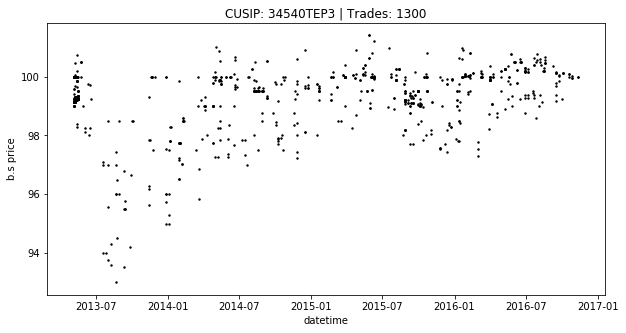

In [5]:
# Previewing a random bond

test_id = IDS[23]
bond1 = data1[data1['cusip_id'] == test_id]
plot_price(bond1, test_id, [])

In [6]:
def subset_CUSIPS(data, threshold, num_bonds):
    
    ids = data['bond_sym_id'].unique()
    prev_indicies = set()
    subset_ids = []
    
    while len(subset_ids) != num_bonds:
        ID = rand.randint(0,len(ids)-1)
        if ID not in prev_indicies:
            bond = data[data['bond_sym_id'] == ids[ID]]
            t0 = bond['datetime'].min() ; t1 = bond['datetime'].max()
            elapsed_time = (t1-t0).days
            if elapsed_time == 0:
                pass
            else:
                frequency = len(bond)/elapsed_time 
                if frequency > threshold:
                    subset_ids.append(ids[ID])  
                    prev_indicies.add(ID)
    return subset_ids

## Calculating Issue Size

In [7]:
rating = pd.read_csv(os.getcwd()+'/'+'bond_data.csv')
rating['cusip_id'] = rating['issuer_cusip'] + rating['issue_cusip']
rating = rating[(rating['cusip_id']).isin(IDS)]

C:\Users\Landon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,27,42,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Calculating Issue Size 
rating['issue_size'] = rating['offering_amt']*rating['offering_price']

# Dropping rows with Nan values
rating.dropna(subset=['issue_size'])

# Subsetting the data, and sorting based on issue size
rating = rating[
    ['cusip_id','offering_date', 'offering_amt', 
     'offering_price', 'maturity', 'issue_size']].sort_values('issue_size', ascending = False)

rating.head(3)

,cusip_id,offering_date,offering_amt,offering_price,maturity,issue_size
157669,92343VBT0,11SEP13,15000000.0,99.883,15SEP43,1.498245e+09
169235,035242AP1,13JAN16,11000000.0,99.833,01FEB26,1.098163e+09
169236,035242AN6,13JAN16,11000000.0,99.765,01FEB46,1.097415e+09


In [9]:
# testing if rating and data1 map 1-1

print('data1 has the same cusips as rating... {}'.format(set(IDS) == set(rating['cusip_id'].unique())))

data1 has the same cusips as rating... True


C:\Users\Landon\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Landon\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


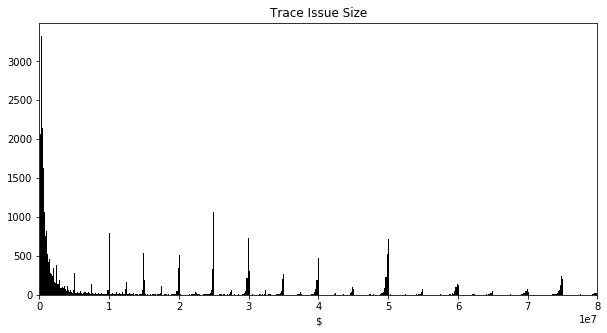

In [10]:
# Plotting distribution (Trimming upper x-axis bound for visualization)

plt.figure(figsize = (10,5))
plt.hist(rating['issue_size'], bins = 10000, color = 'k')
plt.xlabel('$')
plt.xlim([0,.8e8])
plt.title('Trace Issue Size')
plt.show()

In [11]:
quantiles = rating['issue_size'].quantile([i/5 for i in range(1,6)])
print(quantiles)

0.2    3.902000e+05
0.4    1.483860e+06
0.6    1.500000e+07
0.8    4.957960e+07
1.0    1.498245e+09
Name: issue_size, dtype: float64


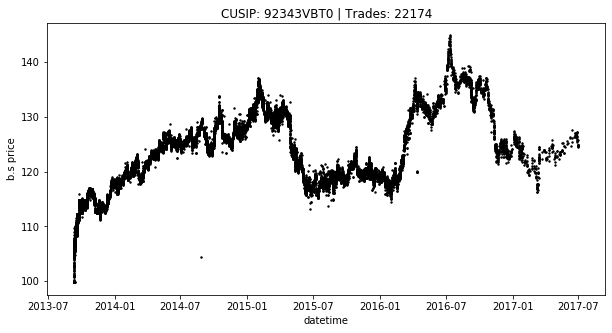

In [12]:
largest_issuance = rating[rating['issue_size'] == rating['issue_size'].max()]
large_id = largest_issuance['cusip_id'].iloc[0]

bond2 = data1[data1['cusip_id'] == large_id]
plot_price(bond2, large_id, [])

## Calculating Turnover 

In [13]:
# Quantify turn over with zero trading day percentage = days traded / tot. trading days
data1.head(3)

,cusip_id,company_symbol,trd_exctn_dt,trd_exctn_tm,scrty_type_cd,wis_fl,cmsn_trd,entrd_vol_qt,rptd_pr,yld_sign_cd,...,sell_cpcty_cd,cntra_mp_id,agu_qsr_id,spcl_trd_fl,trdg_mkt_cd,dissem_fl,SUB_PRDCT,STLMNT_DT,first_trd_ctrl_nb,datetime
0,842400DX8,SCEP,20020805,17:16:40,C,N,N,20000.0,80.000,+,...,P,D,NaN,NaN,S1,N,NaN,NaN,NaN,2002-08-05 17:16:40
1,842400DX8,SCEP,20020805,17:16:40,C,N,N,20000.0,80.000,+,...,P,D,NaN,NaN,S1,N,NaN,NaN,NaN,2002-08-05 17:16:40
2,92929QAA5,WMI,20020912,7:40:45,C,N,N,15000.0,101.583,+,...,P,C,NaN,NaN,S1,N,NaN,NaN,NaN,2002-09-12 07:40:45


In [14]:
# unique trading years
trding_days = pd.Series((data1['trd_exctn_dt']).unique())

# testing for 'bond1'
t0 = bond1['trd_exctn_dt'].min()
t1 = bond1['trd_exctn_dt'].max()

actual_days = bond1['trd_exctn_dt'].unique()
tot_days = trding_days[(trding_days >= t0) & (trding_days <= t1)]

print('Actual Trading Days: ', len(actual_days))
print('Total Trading Days: ', len(tot_days))
print("Bond1 turnover = {}".format(round(len(actual_days)/len(tot_days), 4)))

Actual Trading Days:  251
Total Trading Days:  1075
Bond1 turnover = 0.2335


In [15]:
def calculate_turnover(bond):
        actual_days = bond['trd_exctn_dt'].unique()
        t0 = actual_days.min()
        t1 = actual_days.max()
        
        tot_days = trding_days[(trding_days >= t0) & (trding_days <= t1)]
        turnover = len(actual_days)/len(tot_days)
        return turnover

## Generating Test Data

In [16]:
class TRACE_data(object):
    def __init__(self, bond_data, rating_data):
        self.bond_data = bond_data
        self.rating_data = rating_data
        self.trading_days = pd.Series((bond_data['trd_exctn_dt']).unique())
        self.IDS = bond_data['cusip_id'].unique()
        self.buckets = self.create_buckets()
        
    def create_buckets(self):
        issue = self.rating_data['issue_size'].quantile([i/5 for i in range(1,6)]).tolist()
        turn = [i/5 for i in range(1,6)]
        buckets = {(issue[i],issue[i+1],turn[j],turn[j+1]):[] for i in range(1,5-1) for j in range(1,5-1)}
        return buckets
    
    def calculate_turnover(self, bond):
        actual_days = bond['trd_exctn_dt'].unique()
        t0 = actual_days.min()
        t1 = actual_days.max()
        
        # calculating ratio of the days a bond was traded over total actual trading days
        tot_days = self.trading_days[(self.trading_days >= t0) & (self.trading_days <= t1)]
        turnover = len(actual_days)/len(tot_days)
        return turnover
                
    def fill_buckets1(self, n):
        
        dict_size =  {(i[0],i[1]):[] for i in self.buckets}
        dict_turnover = {(i[2],i[3]):[] for i in self.buckets}
        
        for key in dict_size:
            
            subset = self.rating_data[(self.rating_data['issue_size'] >= key[0]) & (self.rating_data['issue_size'] < key[1])]
            unique_ids = subset['cusip_id'].unique()
            
            while len(set(dict_size[key])) < n:
                random_id = unique_ids[random.randint(0,len(unique_ids)-1)]
                dict_size[key].append(random_id)
                
        bucket_count = len(dict_turnover)
        while sum([len(i) for i in dict_turnover.values()]) < n*bucket_count:
            
            random_id = self.IDS[random.randint(0,len(self.IDS)-1)]
            bond = self.bond_data[self.bond_data['cusip_id'] == random_id]
            turnover = calculate_turnover(bond)
            
            if turnover != np.nan:
                for key in dict_turnover:
                    if (len(dict_turnover[key]) < n) and (turnover >= key[0] and turnover < key[1]):
                        dict_turnover[key].append(random_id)   
        return dict_size, dict_turnover

In [17]:
survey_data = TRACE_data(data1, rating).fill_buckets1(20)

In [18]:
a = list(survey_data[0].values())
b = list(survey_data[1].values())
my_ids = [i for _ in a for i in _]+[i for _ in b for i in _]

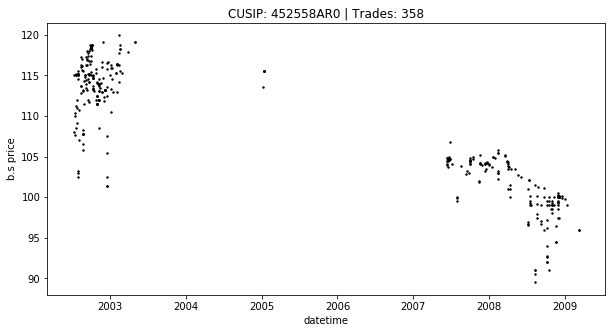

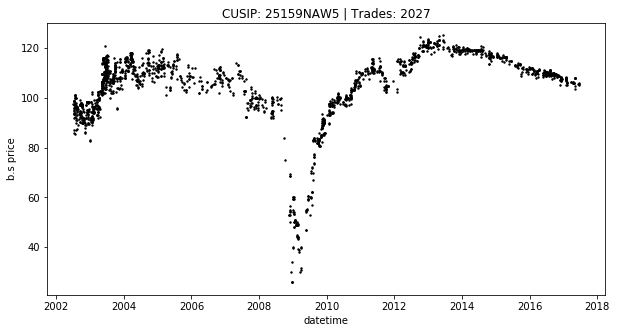

In [22]:
for ID in range(2):
    bond = data1.loc[data1['cusip_id'] == my_ids[ID]]
    plot_price(bond, my_ids[ID], [])

In [111]:
test_data = data1[(data1['cusip_id']).isin(my_ids)][['cusip_id', 'rptd_pr', 'entrd_vol_qt', 'rpt_side_cd', 'datetime']]
test_data['index'] = [i for i in range(len(test_data))]

In [20]:
#test_data.to_csv('test_data.csv', encoding='utf-8', index=False)